In [ ]:
%conda install -c conda-forge matplotlib 
%conda install -c anaconda scipy
!pip install tqdm h5py zarr pillow numpy imgaug==0.4.0 mahotas #imgaug has dependency on previous packages
!pip install scikit-image
!pip install tensorboard
!pip install torchsummary

In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
from IPython.display import Image

# display(HTML("<style>.container { width:100% !important; }</style>"))
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as transforms
from torchvision.transforms import functional as func_transforms
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from imgaug.augmentables.heatmaps import HeatmapsOnImage


import glob
import zarr
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from colormap import *
from unet_fov import *

torch.backends.cudnn.benchmark = True

In [2]:
# decompress data
from shutil import unpack_archive
unpack_archive('data_epithelia.tar.gz', './')

In [3]:
import os
os.getcwd()

'/home/fabian/projects/phd/teaching/image-analysis-tutorial'

Data
-------
For the third task we are using a set of images showing epithelia cells

All images show epithelia tissue. There is no background in the images, only cell membrane/boundary and cell interior.
There are 24 images in the training set, 8 in the validation set and 8 in the test set.

Two example samples can be seen below.

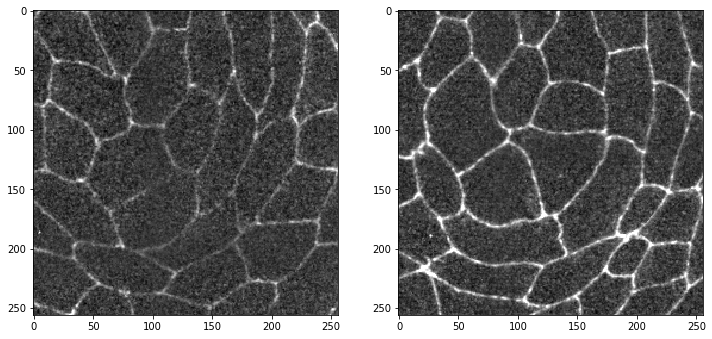

In [ ]:
Image(filename='epithelia.png') 

In [ ]:
'''
inspect the structure of data

 └── volumes
     ├── gt_affs (2, 256, 256) uint8--> affinities map, 2 channels
     ├── gt_fgbg (1, 256, 256) uint8--> foreground and background semantic segmentation
     ├── gt_labels (1, 256, 256) uint16--> instance segmentation, each instance has a different integer label
     ├── gt_tanh (1, 256, 256) float32-->squared distance transformation 
     └── raw (1, 256, 256) float32--> raw input for the model
'''

sample_path = glob.glob(os.path.join("data_epithelia", "train", "*.zarr"))
first_data = zarr.open(sample_path[0], 'r')
print(first_data.tree())

/
 └── volumes
     ├── gt_affs (2, 256, 256) uint8
     ├── gt_fgbg (1, 256, 256) uint8
     ├── gt_labels (1, 256, 256) uint16
     ├── gt_tanh (1, 256, 256) float32
     └── raw (1, 256, 256) float32


#TODO: Create the Epithelia_dataset
-------
We will create the Epithelia_dataset, a subclass which inherits from torch.utils.data.Dataset.

When you just have limited number of data for training, data augmentation is essential to get good results.

TODO: Implement the part of **define_augmentation** for training data during training on the fly.Think about what kind of augmentation to use (e.g. flips, rotation, elastic).Use the imgaug library (https://imgaug.readthedocs.io/en/latest/), it provides a very extensive list of available augmentations.

In [ ]:
class ToTensor(object):
    def __call__(self, image, target):
        #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W)
        image = func_transforms.to_tensor(image)
        target = torch.as_tensor(np.asarray(target), dtype=torch.float)
        return image, target

class Epithelia_dataset(Dataset):
    '''
    (subset of the) kaggle data science bowl 2018 dataset.
    The data is loaded from disk on the fly and in parallel using the keras Sequence class.
    This enables the use of datasets that would not fit into main memory and dynamic augmentation.
    Args:
        root_dir (string): Directory with all the images-->"data_epithelia"
        data_type (string): train/val/test, select subset of images
        prediction_type (string): two_class/affinities/sdt
        transform (callable, optional): Optional transform to be applied
        on a sample.
    '''
    def __init__(self, root_dir, data_type, prediction_type="two_class",return_filename=False):
        self.data_type=data_type
        self.samples = glob.glob(os.path.join(root_dir, data_type, "*.zarr"))
        self.prediction_type = prediction_type
        self.return_filename=return_filename
        self.define_augmentation()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = zarr.open(self.samples[idx], 'r')
        raw = np.array(data['volumes/raw'])
   
        if self.prediction_type == "two_class":
            label = np.array(data['volumes/gt_fgbg'])
            label = np.logical_not(label)
            label = ndimage.binary_dilation(label, iterations=2)
            label = label.astype(np.uint8)
        elif self.prediction_type == "affinities":
            label = np.array(data['volumes/gt_affs'])
        elif self.prediction_type == "sdt":
            label = np.array(data['volumes/gt_tanh'])
            
          
        if self.data_type == "train":    
            raw = np.transpose(raw, [1,2,0]) # CHW -> HWC
            label = np.transpose(label, [1,2,0]) # CHW -> HWC
            raw, label = self.augment_sample(raw, label)          
            raw = np.transpose(raw, [2,0,1]) # HWC -> CHW
            label = np.transpose(label, [2,0,1]) # HWC -> CHW
        else:
            pass
        
        raw = np.transpose(raw, [1,2,0]) # CHW -> HWC       
        raw, label = self.to_tensor(raw, label)
       
     
      
        if self.return_filename==True:
            return raw, label, self.samples[idx]
        else:
            return raw, label
    
    def define_augmentation(self):
      
        ###########################################################################
        # TODO (optional): Define your augmentation pipeline                      #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        self.transform = iaa.Identity()

        # define self.transfrom by looking into the imgaug package reference
        # self.transform = iaa.Sequential([
        #     iaa.Fliplr(0.5),
        #     iaa.Flipud(0.5),
        #    ...
        # ], random_order=True)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        self.to_tensor = ToTensor()
    
    def augment_sample(self, raw, labels):
        # this code makes sure that the same geometric augmentations are applied
        # to both the raw image and the label image
        if self.prediction_type in ["sdt"]:
            labels = HeatmapsOnImage(labels, shape=raw.shape, min_value=-1.0, max_value=1.0)
            raw, labels = self.transform(image=raw, heatmaps=labels)
        else:
            labels = SegmentationMapsOnImage(labels, shape=raw.shape)
            raw, labels = self.transform(image=raw, segmentation_maps=labels)
            
        labels = labels.get_arr()
        # some pytorch version have problems with negative indices introduced by e.g. flips
        # just copying fixes this
        labels = labels.copy()
        raw = raw.copy()
        
        return raw, labels

#TODO: Predefine some conditions for CNN training
-------
We have three types of labels("two_class","affinities","sdt") to train the CNN.

For each case, we should define the corresponding output channel numbers, final activation layer, criterion(loss function).It would be clear to fill in these conditions after you look through the part of code about how we define training process.

TODO: Please fill in the missing code and uncomment one of the **prediction_type** to start your training.

In [ ]:
###########################################################################
# TODO: Uncomment the prediction_type (and corresponding conditions)      #
#       you would like to use for this exercice                           #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#prediction_type = "two_class" # same as fg/bg
#prediction_type = "affinities"
#prediction_type = "sdt"

if prediction_type == "two_class":    
    #out_channels = 
    #activation = 
    #criterion =
    pass
    
elif prediction_type == "affinities":
    #out_channels = 
    #activation = 
    #criterion =
    pass
    
elif prediction_type == "sdt":
    #out_channels = 
    #activation = 
    #criterion =
    pass
    
else:
    raise RuntimeError("invalid prediction type")
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

Create our input datasets, ground truth labels are chosen depending on the type:

In [ ]:
train_data = Epithelia_dataset("data_epithelia", "train", prediction_type=prediction_type)
val_data = Epithelia_dataset("data_epithelia", "val", prediction_type=prediction_type)
test_data = Epithelia_dataset("data_epithelia", "test", prediction_type=prediction_type)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

Let's have a look at some of the raw data and labels:


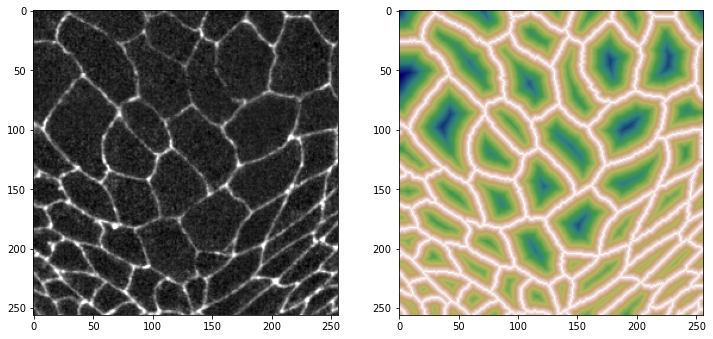

In [ ]:
# repeatedly execute this cell to get different images
dataiter=iter(train_loader)
images, labels = dataiter.next()

rnd = random.randrange(len(images)) #train_loader has batch_size=8
image = images[rnd]
label = labels[rnd]

if prediction_type == "affinities":
    label = label[0] + label[1] # affinities-type label has two channels

fig=plt.figure(figsize=(12, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(label), cmap='gist_earth')
plt.show()

#TODO: Define our U-Net
==============
As before, we define our neural network architecture and can choose the depth and number of feature maps at the first convolution.

This neural network is composed by stacking one UNet instance and one convolution layer. The UNet Class is defined in the **unet_fov.py** file and we use the default setting that the number of feature maps of the UNet insatnce output will be eqaul to the number of feature maps at the first convolution. Then we use one more convolution layer with kernel_size=1 to generate the final output with number of feature maps equal to what we want.

For the meaning of parameters of the UNet class, please refer to the **unet_fov.py** file.

#TODO: Please fill in the missing part of code about how to define the **net**.

In [ ]:
width = 256
height = 256

###########################################################################
# TODO: Define the net and uncomment the following code                   #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# net = torch.nn.Sequential(
#     UNet(in_channels=1,
#     num_fmaps=,
#     fmap_inc_factors=,
#     downsample_factors=[[2,2],[2,2],[2,2]],
#     activation='ReLU',
#     padding='same',
#     constant_upsample=False
#     ),
#     torch.nn.Conv2d(in_channels= , out_channels=out_channels, kernel_size=1, padding=0, bias=True))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

receptive_field, _ = net[0].get_fov()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
net.to(device)

print("Receptive field of view: {}".format(receptive_field))
summary(net,(1,height,width))

#TODO: Training
=======

Before we have already defined criterion for different prediction types.
Now we first define the optimizer(try playing with the learning rate, a higher learning rate can lead to faster training, but also to divergence or lower performance).

The train function has already been implemented. Our default setting is

1.calculate loss, pixel-wise accuracy, precision and recall four metrics when prediction_type=="two_class", 

2.calculate loss and pixel-wise accuracy when prediction_type=="affinities",

3.calculate loss when prediction_type=="sdt".

The corresponding metrics will also be written into the tensorboard. (Note: we don't print the pixel-wise accuracy but you can also add one more line code to print it)

#TODO: Please define the optimizer(and the corresponding learning rate).

In [ ]:
###########################################################################
# TODO: Define the optimzer                                              #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#optimizer = 


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

def do_training(data_loader, tb_writer_train,tb_writer_val, num_epochs=100, start_epoch=0,prediction_type=None):
    

    for epoch in range(start_epoch, start_epoch+num_epochs):  # loop over the dataset multiple times
       
        train_loss, train_acc, train_precision, train_recall = do_epoch(data_loader, "train", prediction_type)
        with torch.no_grad():
            val_loss, val_acc, val_precision, val_recall = do_epoch(val_loader, "val", prediction_type) 
        write_train_val_summaries(tb_writer_train, tb_writer_val,
                              train_loss, val_loss, train_acc,val_acc,
                              train_precision, val_precision,
                              train_recall, val_recall, epoch * len(data_loader))
        #The weight histogram will be written into the tb_writer_train
        net[0].save_weight_histogram(tb_writer_train, epoch)
        if prediction_type =="two_class":    
            print(f'Epoch {epoch + 1}, train-loss: {train_loss:.4f} - train_precision:{train_precision:.4f} - train_recall: {train_recall:.4f}'+
                  f' - val_loss:{val_loss:.4f} -val_precision:{val_precision:.4f} -val_recall:{val_recall:.4f}')
            #print(f'Epoch {epoch + 1}, train_acc: {train_acc:.4f} - val_acc: {val_acc}'）
        else:
            print(f'Epoch {epoch + 1}, train-loss: {train_loss:.4f} - val_loss:{val_loss:.4f}')

        
           

    print('Finished Training')
    #save model
    torch.save({'epoch': epoch,'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss}, f"model_epithelia_{epoch}.pth")
    tb_writer_train.close()
    tb_writer_val.close()

      
            
def do_epoch(data_loader, mode,prediction_type):
    running_loss = 0.0
    epoch_pixel_acc=[]
    if prediction_type =="two_class":
        epoch_precision=[]
        epoch_recall=[]
    # calling enumerate on data_loader resets it
    for i, data in enumerate(data_loader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs = inputs.to(device)
        outputs = net(inputs)
        labels = labels.to(device)
        
        loss = criterion(outputs, labels)
        if activation:
            outputs = activation(outputs)
        if mode == "train":
            loss.backward()
            optimizer.step()
        elif mode == "val":
            pass
        
        if prediction_type=="two_class":
            pixel_acc=compute_metrics(outputs,labels,"pixel_accuracy")
            precision=compute_metrics(outputs,labels,"precision")
            recall=compute_metrics(outputs,labels,"recall")
            epoch_pixel_acc.append(pixel_acc)
            epoch_precision.append(precision)
            epoch_recall.append(recall)
        elif prediction_type=="affinities":
            pixel_acc=compute_metrics(outputs,labels,"pixel_accuracy")
            epoch_pixel_acc.append(pixel_acc)
        else:
            pass

        # accumulate statistics
        running_loss += loss.item()
  

    if prediction_type=="two_class":
        return running_loss/i, np.mean(epoch_pixel_acc),np.mean(epoch_precision),np.mean(epoch_recall)
    elif prediction_type=="affinities":
        return running_loss/i, np.mean(epoch_pixel_acc),None, None
    else:
        return running_loss/i, None ,None, None

def compute_metrics(outputs,labels,key_word="pixel_accuracy"):
    '''
    for prediction_type == "two_class"
        
        output: torch.tensor, [N, C, H, W], value in (0, 1)
        
        label: torch.tensor, [N, C, H, W], value in {1, 0}
        
    key_word:
          pixel_accuracy
          precision=tp/(tp+fp)
          recall=tp/(tp+fn)
    '''
    metrics_list=["pixel_accuracy","percision","recall"]
    if device.type == 'cuda':
        outputs=outputs.cpu()
        labels=labels.cpu()
    pred=torch.ge(outputs, 0.5)

    if key_word =="pixel_accuracy":
        correct=torch.eq(pred, labels).sum().item()
        total=labels.numel() #return total number of elements
        metric=correct/total
    elif key_word =="precision":
        tp=torch.sum(labels[pred==1]).item()
        metric=tp/(labels==1).sum()
    elif key_word =="recall":
        tp=torch.sum(labels[pred==1]).item()
        metric=tp/(pred==1).sum()
    else:
        raise NotImplementedError(f"Only metrics available are: {metrics_list}")

    return metric
    
def write_train_val_summaries(tb_writer_train, tb_writer_val,
                              train_loss, val_loss, train_acc,val_acc,
                              train_precision, val_precision,
                              train_recall, val_recall, global_step):
    if train_loss is not None:
        tb_writer_train.add_scalar('train/val loss',train_loss, global_step)
    if train_acc is not None:
        tb_writer_train.add_scalar('train/val accuracy',train_acc,global_step)
    if train_precision is not None:
        tb_writer_train.add_scalar('train/val precision',train_precision, global_step)
    if train_recall is not None:
        tb_writer_train.add_scalar('train/val recall',train_recall,global_step)
    if val_loss is not None:
        tb_writer_val.add_scalar('train/val loss',val_loss, global_step)
    if val_acc is not None:
        tb_writer_val.add_scalar('train/val accuracy',val_acc,global_step)
    if val_precision is not None:
        tb_writer_val.add_scalar('train/val precision',val_precision, global_step)
    if val_recall is not None:
        tb_writer_val.add_scalar('train/val recall',val_recall,global_step)

#TODO: Define the training epochs and strat to train
=======

Define the number of epochs and start to train the net. 

In [ ]:
###########################################################################
# TODO: Define the number of epochs for training                          #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#num_epochs = 


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
start_epoch = 0

if start_epoch == 0:
    os.makedirs("runs", exist_ok=True)
    run_name1="runs/run_" + "epithelia_segmentation" + "_" + datetime.datetime.now().strftime('%y%m%d_%H%M%S')+"_train"
    run_name2="runs/run_" + "epithelia_segmentation" + "_" + datetime.datetime.now().strftime('%y%m%d_%H%M%S')+"_val"
    tb_writer_train=SummaryWriter(run_name1)#  for train_data
    tb_writer_val=SummaryWriter(run_name2)# for val_data

do_training(train_loader, tb_writer_train,tb_writer_val, num_epochs=num_epochs, 
            start_epoch=start_epoch,prediction_type=prediction_type)


To visualize our results we now use Tensorboard. This is a very useful extension for your browser that let's you look the weights and the metrics over time.

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=runs

Postprocessing
=============

In contrast to the semantic segmentation we postprocessing to extract the final segmentation is a bit more involved and consists of x steps:
- based on the prediction we define a surface
- we extract the maxima from this surface
- we use the maxima as seeds in an off-the-shelf watershed algorithm
- and mask the result with the foreground
The foreground areas covered by the watershed from each seed point correspond to the instances.
The resulting instances are then matched to the ground truth instances (at least 50% overlap) to get our final score (averaged over all instances and all test images)

In [ ]:
%reload_ext autoreload
%autoreload 2
from label import *
from evaluate import *

avg = 0.0

#create a test_loader which can return the filename. The filename will be one of the input element of evaluate function
special_test_data = Epithelia_dataset("data_epithelia", "test", prediction_type=prediction_type,return_filename=True)
special_test_loader = DataLoader(special_test_data, batch_size=1, shuffle=False)


for idx, data in enumerate (special_test_loader):
    inputs, labels, filename = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    pred=net(inputs).detach()
    if activation:
        pred = activation(pred)
    # thresholds are 
    if prediction_type == "two_class":
        fg_thresh = 0.7
        seed_thresh = 0.8 
    elif prediction_type == "sdt":
        fg_thresh = 0.0
        seed_thresh = -0.14
    elif prediction_type == "affinities":
        fg_thresh = 0.9
        seed_thresh = 0.95
    if device.type == 'cuda':
        inputs=inputs.cpu()
        labels=labels.cpu()
        pred=pred.cpu()
    else:
        pass 
    image = np.squeeze(inputs.numpy())
    gt_labels = np.squeeze(labels.numpy())
    pred=np.squeeze(pred.numpy())
    if prediction_type == "affinities":
        gt_labels = gt_labels[0] + gt_labels[1]
    
    if prediction_type =="two_class":
        thresh = pred >= fg_thresh
        #thresh = 1 - thresh
        thresh=~thresh
        labelling, _ = ndimage.label(thresh)
        surface = pred        
    else:
        labelling, surface = label(pred, prediction_type, fg_thresh=fg_thresh, seed_thresh=seed_thresh)
        if prediction_type == "affinities":
            gt_labels = 1 - gt_labels
        
    ap, precision, recall, tp, fp, fn = evaluate(labelling,filename[0])
    avg += ap
    labelling = labelling.astype(np.uint8)

    print(f"average precision: {ap}, precision: {precision}, recall: {recall}")
    print(f"true positives: {tp}, false positives: {fp}, false negatives: {fn}")
    
    fig=plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 4, 1)
    ax.set_title("raw")
    plt.imshow(np.squeeze(image))
    ax = fig.add_subplot(1, 4, 2)
    ax.set_title("gt labels")
    plt.imshow(np.squeeze(gt_labels))
    
    ax = fig.add_subplot(1, 4, 3)
    ax.set_title("prediction")
    plt.imshow(np.squeeze(surface))
    ax = fig.add_subplot(1, 4, 4)
    ax.set_title("pred segmentation")
    plt.imshow(np.squeeze(labelling), cmap=rand_cmap)

    plt.show()
avg /= (idx+1)
print("average precision on test set: {}".format(avg))



if prediction_type == "two_class":
    epoch_precision=0.0
    epoch_recall=0.0
    for idx, data in enumerate (test_loader,1):
        inputs,labels=data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs=net(inputs)
        precision=compute_metrics(outputs,labels,"precision")
        recall=compute_metrics(outputs,labels,"recall")
        epoch_precision+=precision
        epoch_recall+=recall
    print(f"boundary precision: {epoch_precision/idx}, recall: {epoch_recall/idx}")